<font size="8">**Kaggle Test**</font>

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
path = os.listdir("../../data/digit-recognizer")
print(path)

['test.csv', 'train.csv']


In [3]:
# Read the data
train_data = pd.read_csv('../../data/digit-recognizer/train.csv')
test_data = pd.read_csv("../../data/digit-recognizer/test.csv")

In [4]:
# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255

# Test Data
X_test = test_data.values/255

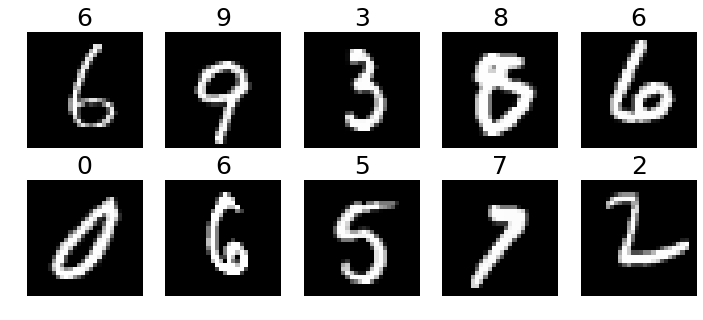

In [5]:
def displayImages(data, label):
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    axes = axes.flatten()

    xsize = data.shape[0]
    # Get random Variables
    idx = np.random.randint(0, xsize, size=10)
    for i in range(10):
        axes[i].imshow(data[idx[i],:].reshape(28,28), cmap='gray')
        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(str(int(label[idx[i]])), color= 'black', fontsize=25)
    plt.show()

displayImages(X_train, y_train)

In [52]:
print("Train")
print(X_train.shape)
print(y_train.shape)

print("Test")
print(X_test.shape)

Train
(42000, 784)
(42000,)
Test
(28000, 784)


In [104]:
num_classes = 10
image_size = 28  # Pixel width and height.

train = 0.95
train_size = int(X_train.shape[0]*train)
valid_size = int(X_train.shape[0]*(1.0 - train)/2.0)
test_size = int(X_train.shape[0]*(1.0 - train)/2.0)

print("train_size: %0.d"%train_size)
print("valid_size: %0.d"%valid_size)
print("test_size: %0.d"%test_size)

train_size: 39900
valid_size: 1050
test_size: 1050


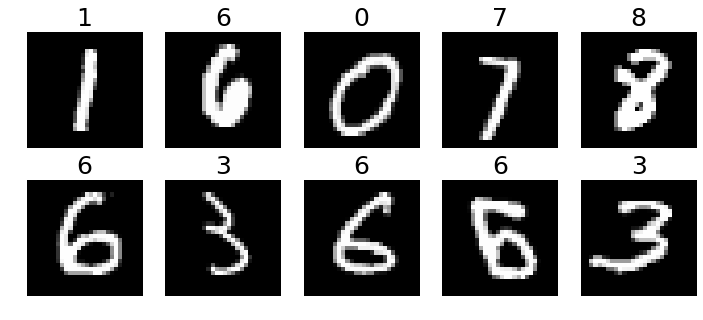

In [105]:
def shuffle_data(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
# Mix all the data
shuffle_data(X_train, y_train)

# Check if they are still ok
displayImages(X_train, y_train)

In [107]:
# Get Train Data
start_t = 0
end_t = train_size
train_dataset = X_train[start_t:end_t,:]
train_labels = y_train[start_t:end_t]

# Get Validation Data
start_t = train_size
end_t = valid_size + train_size
valid_dataset = X_train[start_t:end_t,:]
valid_labels = y_train[start_t:end_t]

# Get Test Data
start_t = valid_size + train_size
end_t = valid_size + train_size + test_size
test_dataset = X_train[start_t:end_t,:]
test_labels = y_train[start_t:end_t]

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (39900, 784) (39900,)
Validation: (1050, 784) (1050,)
Testing: (1050, 784) (1050,)


In [108]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

Training Data

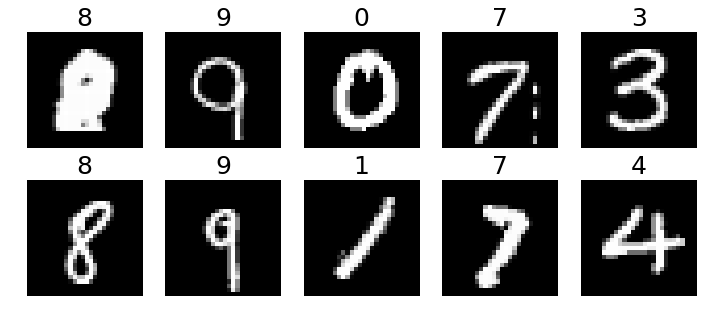

In [92]:
# Check if they are still ok
displayImages(train_dataset, train_labels)

Validation

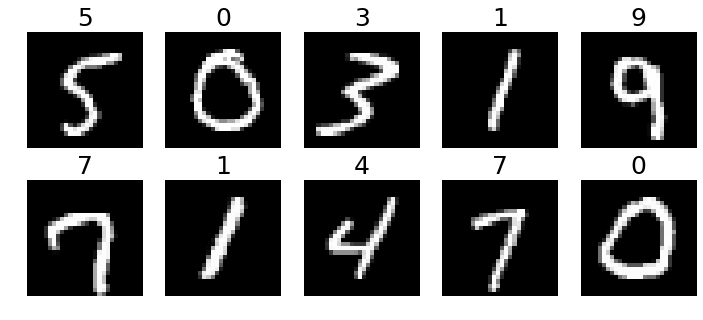

In [93]:
# Check if they are still ok
displayImages(valid_dataset, valid_labels)

Test

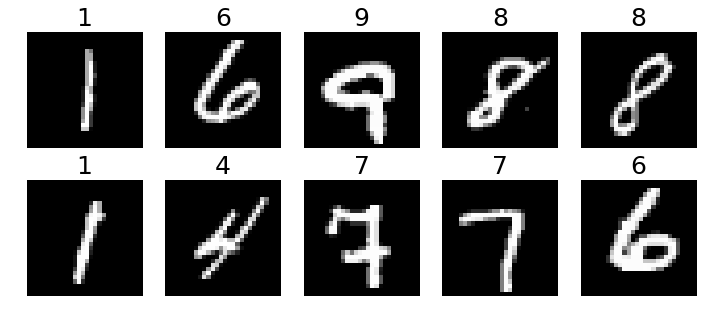

In [94]:
# Check if they are still ok
displayImages(test_dataset, test_labels)

In [95]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable = False
    images2.flags.writeable = False
    start = time.clock()
    #hash1 = set([hash(image1.data) for image1 in images1])
    #hash2 = set([hash(image2.data) for image2 in images2])
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

/home/zarate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/zarate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


Number of overlaps between training and test sets: 0. Execution time: 0.16186500000003434.
Number of overlaps between training and validation sets: 0. Execution time: 0.1659300000001167.
Number of overlaps between validation and test sets: 0. Execution time: 0.0031559999999899446.



<font size="5">**First test using sklearn**</font>

In [109]:
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
print(train_dataset.shape)
print(test_dataset.shape)

(39900, 784)
(1050, 784)



Training on 50 examples
Error rate: 35.62%
Accuracy: 64.38%,  when sample_size = 50


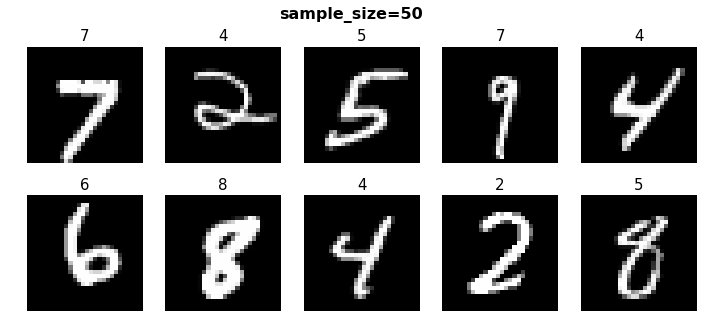


Training on 100 examples
Error rate: 24.38%
Accuracy: 75.62%,  when sample_size = 100


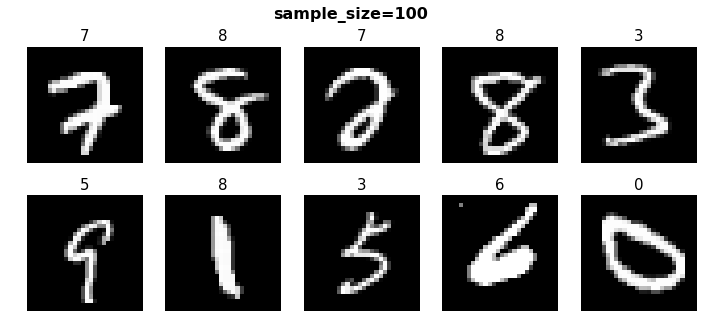


Training on 1000 examples
Error rate: 13.05%
Accuracy: 86.95%,  when sample_size = 1000


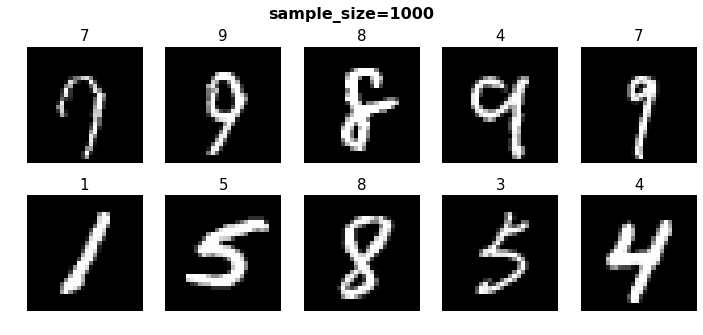


Training on 42000 examples
Error rate: 7.90%
Accuracy: 92.10%,  when sample_size = 42000


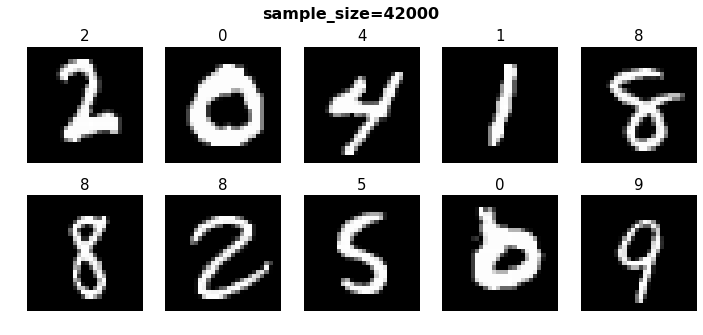

In [110]:
from sklearn.metrics import classification_report, zero_one_loss
import random

def disp_sample_dataset(dataset, labels, title=None):
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    axes = axes.flatten()

    xsize = dataset.shape[0]
    # Get random Variables
    idx = np.random.randint(0, xsize, size=10)
    for i in range(10):
        axes[i].imshow(dataset[idx[i],:].reshape(28,28), cmap='gray')
        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(str(int(labels[idx[i]])), color= 'black', fontsize=15)
    plt.show()

def train_and_predict(sample_size):
    print ('\nTraining on %d examples' % sample_size)
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state = 413)
    #regr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)
            
    # Prepare training data
    X_train = train_dataset[:sample_size]
    y_train = train_labels[:sample_size]

    # Fit
    model.fit(X_train, y_train)
    
    # Prepare testing data
    X_test = test_dataset
    y_test = test_labels

    pred_labels = model.predict(X_test)

    error_rate = zero_one_loss(y_test, pred_labels)
    print ('Error rate: %.2f%%' % (error_rate*100.0))
    
    print('Accuracy: %.2f%%,  when sample_size = %d'%((model.score(X_test, y_test)*100.0), sample_size))
    disp_sample_dataset(test_dataset, pred_labels, 'sample_size=' + str(sample_size))

for sample_size in  [50, 100, 1000, X_train.shape[0]]:
    train_and_predict(sample_size)

#it does not work with len(train_dataset)
#for sample_size in [50, 100]:


Training on all the Training Data


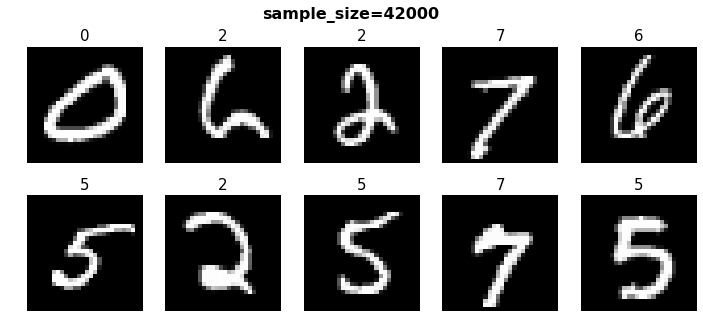

In [111]:
def save_submission(name, dataset, pred_labels):
    # Generating submission using pandas for grading
    submission = pd.DataFrame({'ImageId': range(1, len(dataset) + 1), 'Label': pred_labels })
    submission.to_csv(name, index = False)

def train_and_predict_submission(testData):
    print ('\nTraining on all the Training Data')
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state = 413)
            
    #Use all training data
    X_train = train_dataset
    y_train = train_labels

    # Fit
    model.fit(X_train, y_train)
    
    # predictions
    pred_labels = model.predict(testData)

    #error_rate = zero_one_loss(y_test, pred_labels)
    #print ('Error rate: %.2f%%' % (error_rate*100.0))
    disp_sample_dataset(testData, pred_labels, 'sample_size=' + str(sample_size))
    
    save_submission("simplemnist_sklearn_result.csv", testData, pred_labels)

train_and_predict_submission(X_test)